In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import subprocess

import os
import pandas as pd
import face_recognition
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


In [3]:
df = pd.read_hdf('BD_Emotios_240324.h5')

In [4]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[[165, 166, 161], [165, 166, 161], [165, 166,...","[[[62, 83], [62, 88], [62, 93], [63, 97], [64,...","[[[160, 162, 161], [160, 162, 161], [160, 162,...",bored
1,"[[[164, 166, 161], [165, 167, 162], [164, 166,...","[[[62, 83], [62, 87], [62, 92], [63, 96], [64,...","[[[160, 162, 160], [161, 162, 161], [160, 161,...",bored
2,"[[[165, 165, 163], [165, 165, 163], [164, 165,...","[[[63, 82], [63, 87], [63, 91], [64, 96], [65,...","[[[159, 161, 158], [160, 162, 159], [161, 162,...",bored
3,"[[[165, 166, 162], [165, 165, 164], [165, 165,...","[[[63, 83], [62, 87], [63, 92], [63, 97], [65,...","[[[159, 161, 158], [161, 163, 160], [155, 157,...",bored
4,"[[[165, 166, 161], [166, 167, 162], [165, 167,...","[[[63, 83], [63, 87], [63, 92], [63, 96], [64,...","[[[160, 162, 160], [161, 163, 161], [152, 154,...",bored


In [5]:
print(df['Imagen'].shape)
print(df['Rostro'].shape)

(5037,)
(5037,)


In [9]:
# Separar las características y etiquetas
X = np.array(df['Rostro'])
y = df['Etiqueta']

In [ ]:
X[0].shape

In [8]:
for i in range(X.shape[0]):
    X[i] = np.array(Image.fromarray(X[i]).resize((150,150)))

In [17]:

    
print(X[0].shape)

(150, 150, 3)
(150, 150, 3)


In [18]:
# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes

In [19]:
# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [20]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [21]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [22]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [23]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [24]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)


In [25]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])


In [26]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [27]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    )


Epoch 1/5
126/126 [==============================] - 20s 134ms/step - loss: 1.1062 - accuracy: 0.5051 - val_loss: 0.8414 - val_accuracy: 0.6389
Epoch 2/5
126/126 [==============================] - 17s 131ms/step - loss: 0.9133 - accuracy: 0.5788 - val_loss: 0.8242 - val_accuracy: 0.6726
Epoch 3/5
126/126 [==============================] - 17s 138ms/step - loss: 0.8932 - accuracy: 0.5858 - val_loss: 0.8216 - val_accuracy: 0.6290
Epoch 4/5
126/126 [==============================] - 18s 141ms/step - loss: 0.8614 - accuracy: 0.6128 - val_loss: 0.8324 - val_accuracy: 0.6141
Epoch 5/5
126/126 [==============================] - 17s 138ms/step - loss: 0.8571 - accuracy: 0.6073 - val_loss: 0.7748 - val_accuracy: 0.6687


In [56]:
# Guardar el modelo
#model.save('modelo_cnn.h5')

In [28]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 [==============================] - 1s 15ms/step


In [29]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)

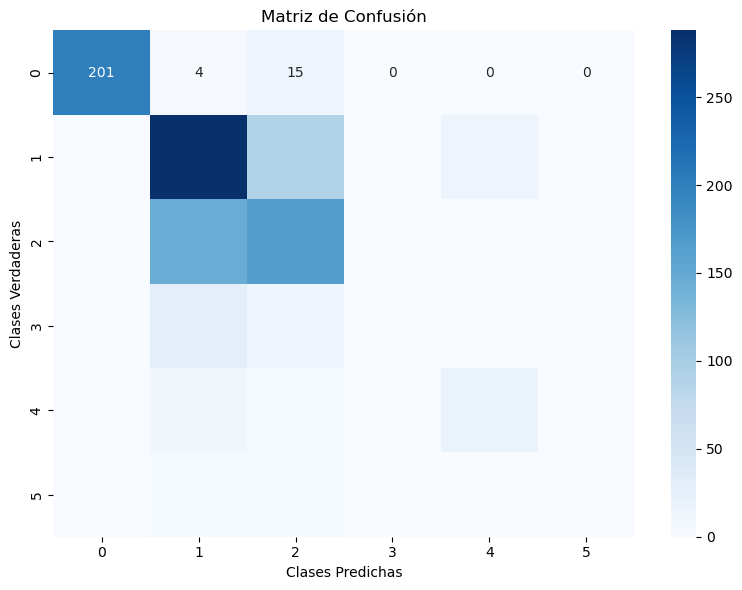

In [30]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()